In [ ]:
! pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir ~/.kaggle

In [ ]:
#! cp kaggle.json ~/.kaggle/

Upload the json file to Google Drive and then copy to the temporary location.

In [ ]:
!cp /content/drive/MyDrive/ColabNotebooks/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json

Change the file permissions to read/write to the owner only

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

**Competitions and Datasets are the two types of Kaggle data**

**1. Download competition data**

If you get 403 Forbidden error, you need to click 'Late Submission' on the Kaggle page for that competition.

In [ ]:
! kaggle competitions download state-farm-distracted-driver-detection

100% 3.99G/4.00G [00:50<00:00, 84.0MB/s]
100% 4.00G/4.00G [00:50<00:00, 85.5MB/s]


In [ ]:
! unzip state-farm-distracted-driver-detection.zip

Streaming output truncated to the last 5000 lines.
  inflating: imgs/train/c7/img_56636.jpg  
  inflating: imgs/train/c7/img_56661.jpg  
  inflating: imgs/train/c7/img_56699.jpg  
  inflating: imgs/train/c7/img_56717.jpg  
  inflating: imgs/train/c7/img_56724.jpg  
  inflating: imgs/train/c7/img_56768.jpg  
  inflating: imgs/train/c7/img_56779.jpg  
  inflating: imgs/train/c7/img_56849.jpg  
  inflating: imgs/train/c7/img_56899.jpg  
  inflating: imgs/train/c7/img_56938.jpg  
  inflating: imgs/train/c7/img_5706.jpg  
  inflating: imgs/train/c7/img_57076.jpg  
  inflating: imgs/train/c7/img_57122.jpg  
  inflating: imgs/train/c7/img_57137.jpg  
  inflating: imgs/train/c7/img_5715.jpg  
  inflating: imgs/train/c7/img_57278.jpg  
  inflating: imgs/train/c7/img_57321.jpg  
  inflating: imgs/train/c7/img_57345.jpg  
  inflating: imgs/train/c7/img_57355.jpg  
  inflating: imgs/train/c7/img_5741.jpg  
  inflating: imgs/train/c7/img_57433.jpg  
  inflating: imgs/train/c7/img_5753.jpg  
  infla

In [ ]:
import numpy as np
import pandas as pd

import os
import glob
import matplotlib.pyplot as plt

from tqdm import tqdm

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.io as io
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split


import tensorflow as tf
import cv2
import random
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score


Import data & Display Some Images

In [ ]:
ls

drive/                imgs/         sample_submission.csv
driver_imgs_list.csv  sample_data/  state-farm-distracted-driver-detection.zip


In [ ]:
train_path = './imgs/train'
for folder in glob.glob(train_path+'/*'):
    folder_name = folder.split('/')[-1]
    print(f'{folder_name} : {len(os.listdir(folder))} images')

c9 : 2129 images
c8 : 1911 images
c6 : 2325 images
c3 : 2346 images
c7 : 2002 images
c5 : 2312 images
c4 : 2326 images
c1 : 2267 images
c0 : 2489 images
c2 : 2317 images


Data is almost balanced

In [ ]:
classes = {
    'c0': 'safe driving',
    'c1': 'texting - right',
    'c2': 'talking on the phone - right',
    'c3': 'texting - left',
    'c4': 'talking on the phone - left',
    'c5': 'operating the radio',
    'c6': 'drinking',
    'c7': 'reaching behind',
    'c8': 'hair and makeup',
    'c9': 'talking to passenger'
}

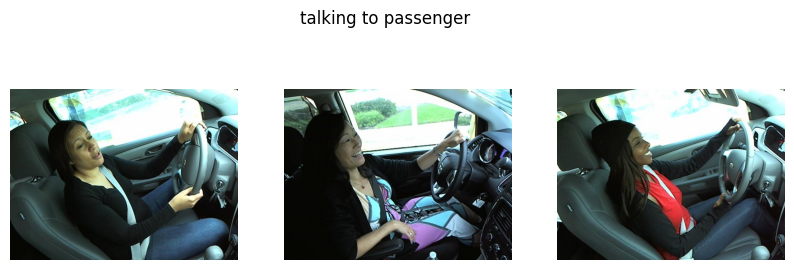

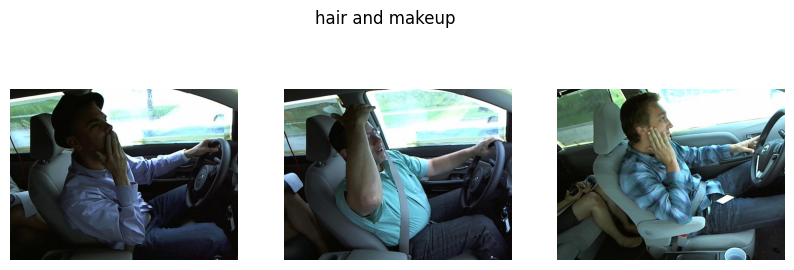

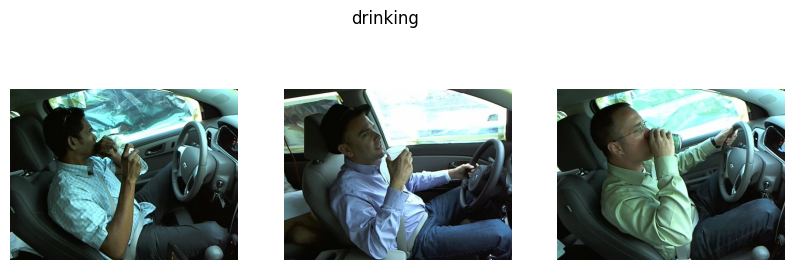

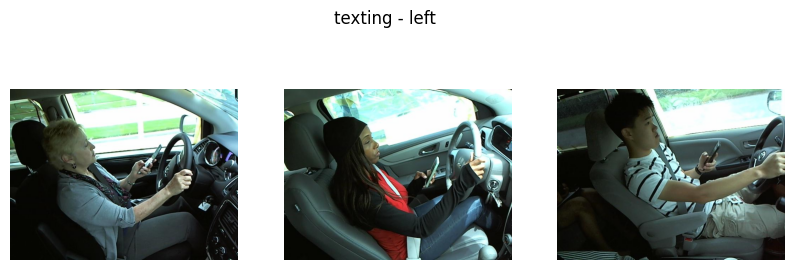

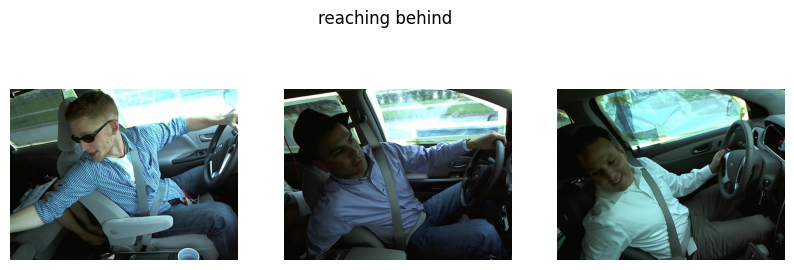

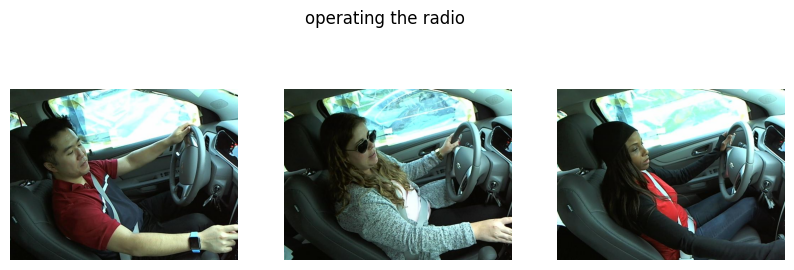

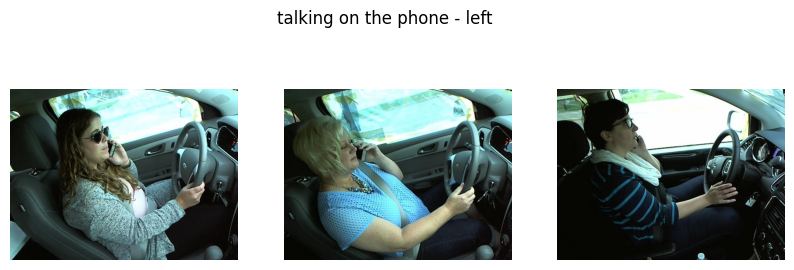

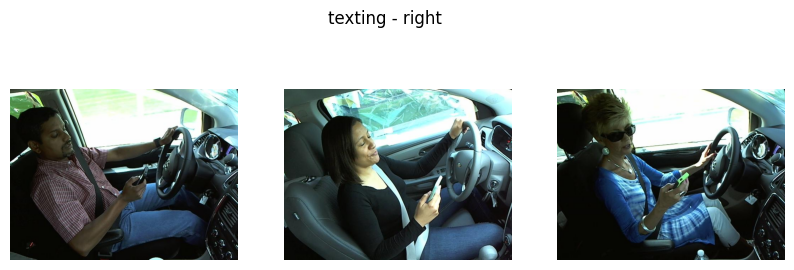

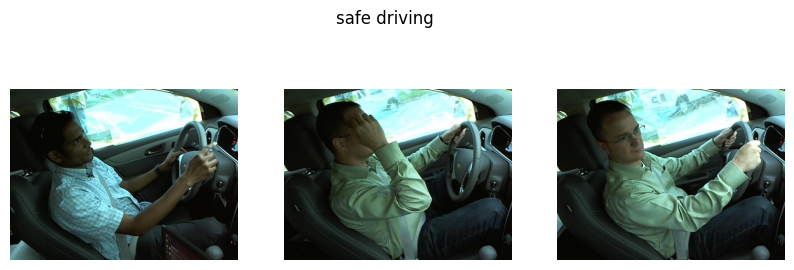

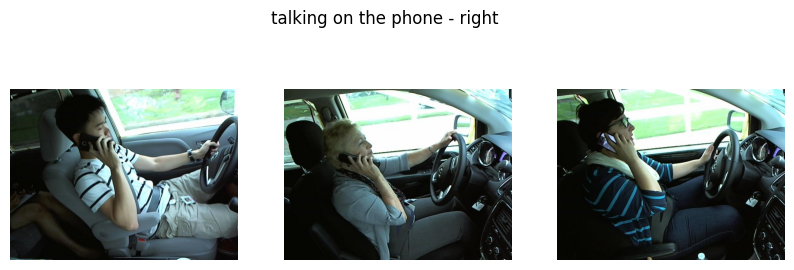

In [ ]:
def show_images(folder_path, num):
    """
    Description:
        Display a random selection of images from the specified folder path.

    Parameters:
        - folder_path (str): The path to the folder containing the images.
        - num (int): The number of images to display.

    Returns:
        None
    """
    images = glob.glob(folder_path+'/*')
    selected_images = np.random.choice(images, num, replace=False)

    fig = plt.figure(figsize=(10, 6))
    columns = 3
    rows = (len(selected_images) // columns) + 1
    for i, image_file in enumerate(selected_images):
        img = plt.imread(image_file)
        ax = fig.add_subplot(rows, columns, i+1)
        ax.imshow(img)
        ax.axis('off')
    class_ = folder_path.split('/')[-1]
    plt.suptitle(classes[class_])
    plt.show()

# show some random images from each class
for folder in glob.glob(train_path+'/*'):
    show_images(folder, 3)

In [ ]:
img_path = './imgs/train/c1/img_100021.jpg'
img = io.read_image(img_path)
img.shape

torch.Size([3, 480, 640])

BaseLine Dense Model

In [ ]:
class BaselineDenseModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(BaselineDenseModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, num_classes)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.view(x.size(0), -1) # flatten the input
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        return self.softmax(x)


input_size = 480*640*3
num_classes = 10

model = BaselineDenseModel(input_size, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

Data Augmentation

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((480, 640)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.RandomAffine(degrees=0, translate=(0.1,0.1), scale=(1.0, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((480, 640)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
dataset = datasets.ImageFolder(root=train_path, transform=train_transform)

In [ ]:
dataset

Dataset ImageFolder
    Number of datapoints: 22424
    Root location: ./imgs/train
    StandardTransform
Transform: Compose(
               Resize(size=(480, 640), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               RandomAffine(degrees=[0.0, 0.0], translate=(0.1, 0.1), scale=(1.0, 1.2))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
class2idx = dataset.class_to_idx
class_indices = {v:k for k, v in class2idx.items()}
class_indices

{0: 'c0',
 1: 'c1',
 2: 'c2',
 3: 'c3',
 4: 'c4',
 5: 'c5',
 6: 'c6',
 7: 'c7',
 8: 'c8',
 9: 'c9'}

In [ ]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

In [ ]:
# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [ ]:
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = test_transform

The issue with this dataset is that we only have the train folder without a separate validation set. To address this, I utilized random_split to split the train data into train and validation subsets. However, a problem arose where the same data augmentation techniques, such as random rotation and horizontal flip, were applied to both the train and validation sets. To rectify this, I modified the transformation pipeline to apply specific augmentation to the train data and specific preprocessing to the validation or new data.

In [ ]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device='cuda'):
    """
    Description:
        Train the given model using the provided data loaders and optimization parameters.

    Parameters:
        - model (torch.nn.Module): The neural network model to train.
        - train_loader (torch.utils.data.DataLoader): DataLoader for training data.
        - val_loader (torch.utils.data.DataLoader): DataLoader for validation data.
        - criterion (torch.nn.Module): The loss function.
        - optimizer (torch.optim.Optimizer): The optimizer used for updating model parameters.
        - num_epochs (int): Number of training epochs (default: 10).
        - device (str): Device to run the training on (default: 'cuda').

    Returns:
        - model (torch.nn.Module): The trained model.
        - history (dict): A dictionary containing training history with keys:
            - 'train_loss': List of training losses for each epoch.
            - 'train_acc': List of training accuracies for each epoch.
            - 'val_loss': List of validation losses for each epoch.
            - 'val_acc': List of validation accuracies for each epoch.

    """

    model.to(device)
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in tqdm(range(num_epochs)):
        # Training phase
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train_images = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, dim=1)
            correct_train += (predicted == labels).sum().item()
            total_train_images += labels.size(0)


        train_accuracy = 100 * correct_train / total_train_images
        avg_train_loss = train_loss / len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val_images = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                correct_val += (predicted == labels).sum().item()
                total_val_images += labels.size(0)


        val_accuracy = 100 * correct_val / total_val_images
        avg_val_loss = val_loss / len(val_loader)

        # Print epoch statistics
        print(f"Epoch [{epoch+1}/{num_epochs}]\nTrain Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

        # Save history
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_accuracy)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_accuracy)

    return model, history

In [ ]:
trained_model, history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5)

 20%|██        | 1/5 [04:50<19:23, 290.88s/it]

Epoch [1/5]
Train Loss: 2.3582, Train Acc: 10.28%, Val Loss: 2.3558, Val Acc: 10.48%


 40%|████      | 2/5 [09:31<14:14, 284.95s/it]

Epoch [2/5]
Train Loss: 2.3582, Train Acc: 10.30%, Val Loss: 2.3558, Val Acc: 10.48%


 60%|██████    | 3/5 [14:12<09:26, 283.21s/it]

Epoch [3/5]
Train Loss: 2.3583, Train Acc: 10.30%, Val Loss: 2.3558, Val Acc: 10.48%


 80%|████████  | 4/5 [18:54<04:42, 282.49s/it]

Epoch [4/5]
Train Loss: 2.3583, Train Acc: 10.30%, Val Loss: 2.3558, Val Acc: 10.48%


100%|██████████| 5/5 [23:31<00:00, 282.24s/it]

Epoch [5/5]
Train Loss: 2.3583, Train Acc: 10.30%, Val Loss: 2.3558, Val Acc: 10.48%


In [ ]:
def plot_performance(history):
    """
    Description:
        Plot the training and validation loss, as well as training and validation accuracy over epochs.

    Parameters:
        - history (dict): A dictionary containing training history with keys:
        - 'train_loss': List of training losses for each epoch.
        - 'train_acc': List of training accuracies for each epoch.
        - 'val_loss': List of validation losses for each epoch.
        - 'val_acc': List of validation accuracies for each epoch.

    Returns:
        None
    """

    epochs = range(1, len(history['train_loss']) + 1)

    # Plot loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'b-', label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

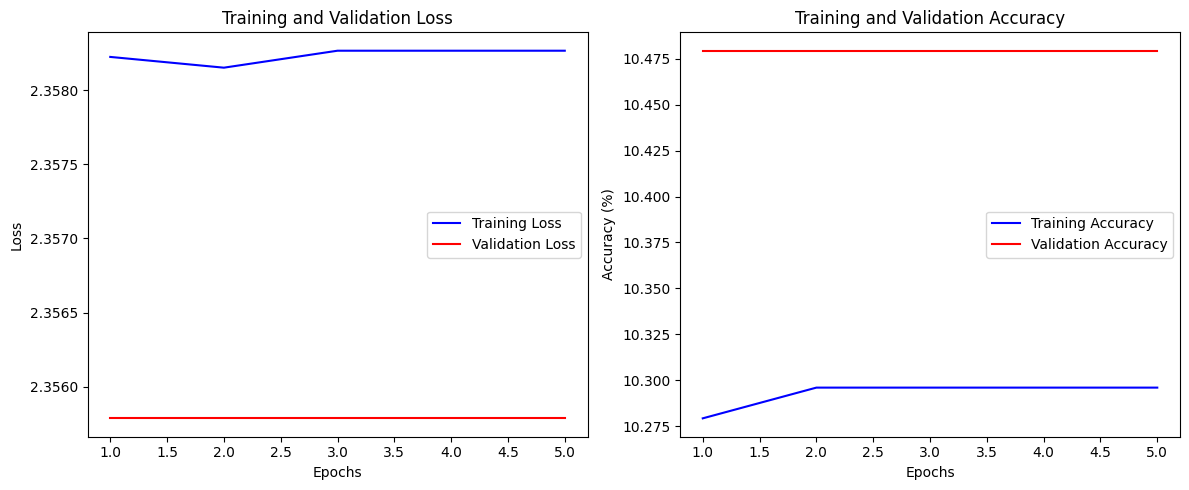

In [ ]:
plot_performance(history)

In [ ]:
def true_pred(test_data,model):
    y_true = []
    y_pred = []
    n = len(test_data)
    sum = 0
    with torch.no_grad():
        for x,y in tqdm(test_data):
            x = x.to(device)
            pred = torch.argmax(model(x),dim=1)
            y_true.extend(list(np.array(y)))
            y_pred.extend(list(np.array(pred.cpu())))
    return y_true,y_pred

In [ ]:
y_true,y_pred = true_pred(val_loader,model)

100%|██████████| 141/141 [00:49<00:00,  2.88it/s]


In [ ]:
accuracy = accuracy_score(y_true,y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_true, y_pred,average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_true,y_pred,average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_true,y_pred,average='weighted')
print('F1 score: %f' % f1)

Accuracy: 0.104794
Precision: 0.010982
Recall: 0.104794
F1 score: 0.019880


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def predict_folder(folder_path, model):
    probabilities_per_image = []
    images = []

    for img_path in glob.glob(folder_path+'/*'):
        image = Image.open(img_path)
        image = test_transform(image).unsqueeze(0) # batch dimension

        model.eval()
        with torch.no_grad():
            image = image.to(device)
            output = model(image)

        # Apply softmax to obtain probabilities
        probabilities = torch.softmax(output, dim=1)
        probabilities = probabilities.squeeze(0).tolist()

        images.append(img_path.split('/')[-1])
        probabilities_per_image.append(probabilities)

    return images, probabilities_per_image

BaseLine CNN

In [ ]:
class BaselineCNN(nn.Module):
    def __init__(self, num_classes):
        super(BaselineCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 37 * 37, 512)  # Adjusted input size based on the output of conv2
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 37 * 37)  # Adjusted reshape based on the output size of conv2
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model_CNN = BaselineCNN(num_classes=10)

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.RandomAffine(degrees=0, translate=(0.1,0.1), scale=(1.0, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
dataset = datasets.ImageFolder(root=train_path, transform=train_transform)

In [ ]:
dataset

Dataset ImageFolder
    Number of datapoints: 22424
    Root location: ./imgs/train
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               RandomAffine(degrees=[0.0, 0.0], translate=(0.1, 0.1), scale=(1.0, 1.2))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
class2idx = dataset.class_to_idx
class_indices = {v:k for k, v in class2idx.items()}
class_indices

{0: 'c0',
 1: 'c1',
 2: 'c2',
 3: 'c3',
 4: 'c4',
 5: 'c5',
 6: 'c6',
 7: 'c7',
 8: 'c8',
 9: 'c9'}

In [ ]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

In [ ]:
# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [ ]:
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = test_transform

In [ ]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

The issue here appears to be memory crashes due to the large size of the images. I tried to solve this issue by reducing batch size and simplifying the model architecture, but the problem persisted. As a solution, resizing the images from (480, 640) to (150, 150) has resolved the problem.

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_CNN.parameters())

In [ ]:
trained_model_CNN, history = train_model(model_CNN, train_loader, val_loader, criterion, optimizer, num_epochs=6)

 17%|█▋        | 1/6 [02:08<10:44, 128.81s/it]

Epoch [1/6]
Train Loss: 1.0706, Train Acc: 65.42%, Val Loss: 0.0852, Val Acc: 97.93%


 33%|███▎      | 2/6 [04:13<08:24, 126.25s/it]

Epoch [2/6]
Train Loss: 0.0475, Train Acc: 98.71%, Val Loss: 0.0378, Val Acc: 98.86%


 50%|█████     | 3/6 [06:19<06:18, 126.18s/it]

Epoch [3/6]
Train Loss: 0.0108, Train Acc: 99.69%, Val Loss: 0.0476, Val Acc: 98.80%


 67%|██████▋   | 4/6 [08:22<04:10, 125.12s/it]

Epoch [4/6]
Train Loss: 0.0192, Train Acc: 99.41%, Val Loss: 0.0348, Val Acc: 99.11%


 83%|████████▎ | 5/6 [10:31<02:06, 126.21s/it]

Epoch [5/6]
Train Loss: 0.0127, Train Acc: 99.68%, Val Loss: 0.0482, Val Acc: 98.75%


100%|██████████| 6/6 [12:34<00:00, 125.78s/it]

Epoch [6/6]
Train Loss: 0.0170, Train Acc: 99.48%, Val Loss: 0.1951, Val Acc: 95.61%


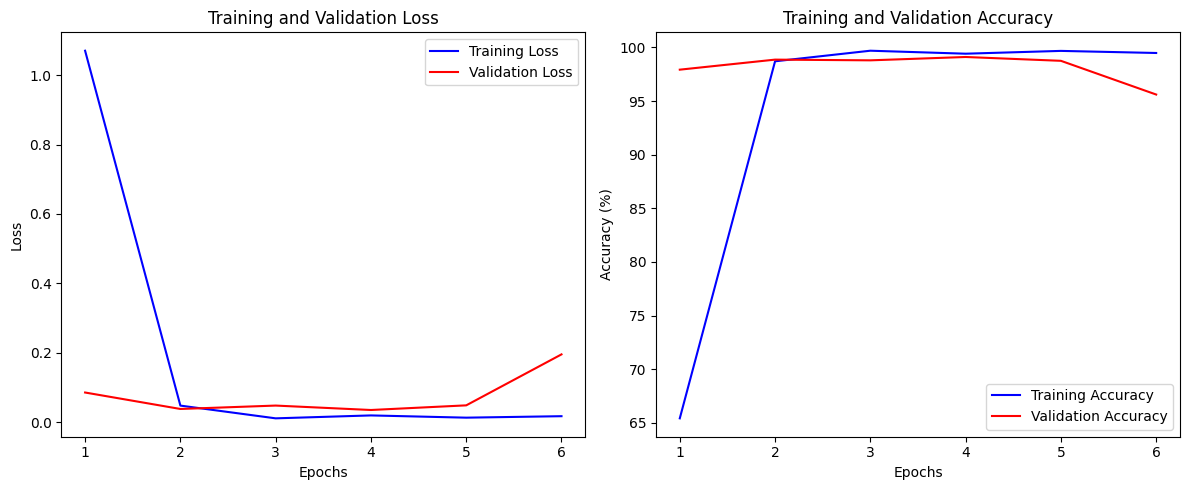

In [ ]:
plot_performance(history)

In [ ]:
def true_pred(test_data,model):
    y_true = []
    y_pred = []
    n = len(test_data)
    sum = 0
    with torch.no_grad():
        for x,y in tqdm(test_data):
            x = x.to(device)
            pred = torch.argmax(model(x),dim=1)
            y_true.extend(list(np.array(y)))
            y_pred.extend(list(np.array(pred.cpu())))
    return y_true,y_pred

In [ ]:
y_true,y_pred = true_pred(val_loader,model_CNN)

100%|██████████| 141/141 [00:21<00:00,  6.44it/s]


In [ ]:
accuracy = accuracy_score(y_true,y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_true, y_pred,average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_true,y_pred,average='weighted')
print('Recall: %f' % recall)


Accuracy: 0.956076
Precision: 0.963182
Recall: 0.956076


In [ ]:
def predict_folder(folder_path, model):
    probabilities_per_image = []
    images = []

    for img_path in glob.glob(folder_path+'/*'):
        image = Image.open(img_path)
        image = test_transform(image).unsqueeze(0) # batch dimension

        model.eval()
        with torch.no_grad():
            image = image.to(device)
            output = model(image)

        # Apply softmax to obtain probabilities
        probabilities = torch.softmax(output, dim=1)
        probabilities = probabilities.squeeze(0).tolist()

        images.append(img_path.split('/')[-1])
        probabilities_per_image.append(probabilities)

    return images, probabilities_per_image

In [ ]:
# Example usage
folder_path = './imgs/test'
images, probabilities_per_image = predict_folder(folder_path, trained_model_CNN)

In [ ]:
torch.save(model.state_dict(), 'model.pth')

In [ ]:
!pip install --upgrade pyngrok

!pip install flask_ngrok

!ngrok authtoken "2QQ7THxU8roD0yEMLjWxrzy4WpR_5WyZg7uxM2SyVkvtACrgs"

!ngrok http 80

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
http - start an HTTP tunnel

USAGE:
  ngrok http [address:port | port] [flags]

AUTHOR:
  ngrok - <support@ngrok.com>

COMMANDS: 
  config          update or migrate ngrok's configuration file
  http            start an HTTP tunnel
  tcp             start a TCP tunnel
  tunnel          start a tunnel for use with a tunnel-group backend

EXAMPLES: 
  ngrok http 80                                                 # secure public URL for port 80 web server
  ngrok http --domain baz.ngrok.dev 8080                        # port 8080 available at baz.ngrok.dev
  ngrok tcp 22                                                  # tunnel arbitrary TCP traffic to port 22
  ngrok http 80 --oauth=google --oauth-allow-email=foo@foo.com  # secure your app with oauth

Paid Features: 
  ngrok http 80 --domain mydomain.com                           # run ngrok with your own custom domain
  ngrok http 80 --allow-cidr 2600:8c00::a03c:91ee:f

In [ ]:
from flask import Flask, request
from flask_ngrok import run_with_ngrok

# Initialize Flask app
app = Flask(__name__)
run_with_ngrok(app)  # Start ngrok when app is run

# Load your model (make sure to adjust the path to your model)
model = torch.load('model.pth')

# Define image preprocessing steps
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  # Adjust according to your model's input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

@app.route('/predict', methods=['POST'])
def predict():
    if 'image' not in request.files:
        return jsonify({'error': 'No image file in request'}), 400

    file = request.files['image']
    try:
        img = Image.open(io.BytesIO(file.read()))
        img = preprocess(img).unsqueeze(0)  # Add batch dimension

        with torch.no_grad():
            output = model(img)
            _, predicted = torch.max(output, 1)
            prediction = predicted.item()

        return jsonify({'prediction': prediction}), 200
    except Exception as e:
        return jsonify({'error': str(e)}), 500

if __name__ == '__main__':
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
Exception in thread Thread-16:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connection.py", line 203, in _new_conn
    sock = connection.create_connection(
  File "/usr/local/lib/python3.10/dist-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/usr/local/lib/python3.10/dist-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py", line 791, in urlopen
    response = self._make_request(
  File "/usr/local/lib/python3.10/dist-packages/urll

In [ ]:
# Define image preprocessing steps
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  # Adjust according to your model's input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


@app.route('/predict', methods=['POST'])
def predict():
    if 'image' not in request.files:
        return jsonify({'error': 'No image file in request'}), 400

    file = request.files['image']
    try:
        img = Image.open(io.BytesIO(file.read()))
        img = preprocess(img).unsqueeze(0)  # Add batch dimension

        with torch.no_grad():
            output = model(img)
            _, predicted = torch.max(output, 1)
            prediction = predicted.item()

        return jsonify({'prediction': prediction}), 200
    except Exception as e:
        return jsonify({'error': str(e)}), 500


In [ ]:
len(probabilities_per_image)

79726

In [ ]:
df1 = pd.DataFrame({'img': images})
df2 = pd.DataFrame(probabilities_per_image, columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
final_sub = pd.concat((df1, df2), axis=1)
final_sub

,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_26090.jpg,8.074912e-07,9.976438e-01,4.369554e-08,1.016777e-03,2.645941e-07,3.650342e-08,5.929415e-04,1.390331e-09,5.750890e-04,0.000170
1,img_9044.jpg,7.253143e-05,6.471064e-06,9.902297e-01,1.336501e-04,1.821281e-03,1.176528e-03,4.956481e-06,4.456118e-05,8.138809e-08,0.006510
2,img_73107.jpg,8.495178e-07,1.658717e-05,1.907082e-09,1.676593e-01,3.095824e-06,1.232298e-06,1.519807e-08,2.013285e-02,3.722275e-01,0.439959
3,img_1068.jpg,2.399227e-05,7.427646e-08,8.693792e-08,3.639867e-05,2.406323e-05,5.763862e-01,3.272188e-03,2.155770e-01,1.032555e-01,0.101425
4,img_60565.jpg,5.643720e-01,2.577499e-01,2.876746e-04,1.055505e-01,1.434839e-02,2.885864e-05,1.964762e-02,1.361298e-05,3.093176e-02,0.007070
...,...,...,...,...,...,...,...,...,...,...,...
79721,img_64694.jpg,2.929735e-09,3.004813e-12,3.793860e-10,8.173188e-10,5.057464e-06,9.999882e-01,2.269568e-11,2.393851e-06,3.206722e-06,0.000001
79722,img_76692.jpg,7.181793e-01,2.327752e-03,1.108264e-04,2.294710e-01,1.886294e-05,5.142880e-03,1.331282e-10,4.284524e-07,3.896529e-07,0.044749
79723,img_96575.jpg,2.683059e-03,3.969239e-04,8.160022e-07,9.141338e-03,5.575024e-03,9.787585e-01,3.375327e-06,3.416015e-03,1.172291e-06,0.000024
79724,img_81909.jpg,1.278450e-04,7.326043e-05,7.044023e-02,4.222963e-07,3.376334e-13,1.137257e-04,5.478020e-06,1.104433e-05,8.945078e-07,0.929227


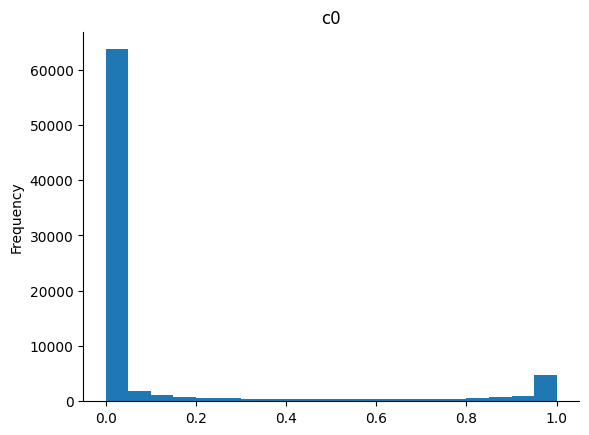

In [ ]:
# @title c0

from matplotlib import pyplot as plt
final_sub['c0'].plot(kind='hist', bins=20, title='c0')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# détecter les valeurs manquantes
final_sub.isnull().sum()

img    0
c0     0
c1     0
c2     0
c3     0
c4     0
c5     0
c6     0
c7     0
c8     0
c9     0
dtype: int64

In [ ]:
#explorer le dataframe vers un fichier CSV
final_sub.to_csv('final_sub.csv', index=False)

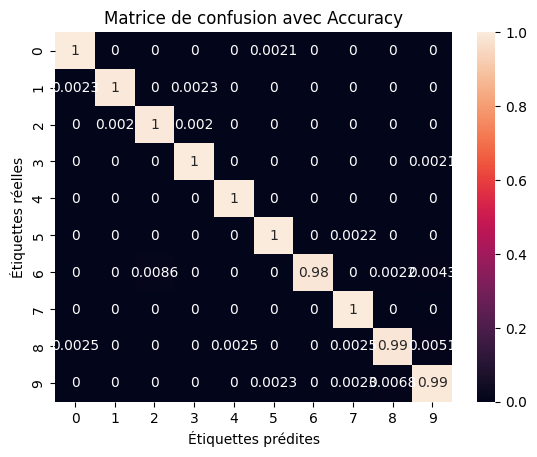

In [ ]:
m = confusion_matrix(y_true, y_pred)
m  = m.astype('float') / m.sum(axis=1)[:, np.newaxis]

sns.heatmap(m,annot=True)
plt.xlabel('Étiquettes prédites')
plt.ylabel('Étiquettes réelles')
plt.title('Matrice de confusion avec Accuracy')
plt.show()


RESNET50

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.RandomAffine(degrees=0, translate=(0.1,0.1), scale=(1.0, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
dataset = datasets.ImageFolder(root=train_path, transform=train_transform)

In [ ]:
class2idx = dataset.class_to_idx
class_indices = {v:k for k, v in class2idx.items()}
class_indices

In [ ]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

In [ ]:
# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [ ]:
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = test_transform

In [ ]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
#Hyperparameters
batch_size = 32
base_learning_rate = 0.001
base_momentum=0.9
initial_epochs = 30
fine_tune_epochs = 40
fine_tune_at = 4
drop_out_rate = 0.2
initial_patience = 3
fine_tune_patience = 2

In [ ]:
# Charger le modèle ResNet50 pré-entraîné
base_model = models.resnet50(pretrained=True)

# Geler les couches du modèle de base
for param in base_model.parameters():
    param.requires_grad = False

# Modifier la dernière couche pour notre tâche (10 classes)
num_ftrs = base_model.fc.in_features
base_model.fc = nn.Sequential(
    nn.Dropout(drop_out_rate),
    nn.Linear(num_ftrs, 10)
)



In [ ]:
# Définir l'optimiseur et la fonction de perte
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(base_model.parameters(), lr=base_learning_rate, momentum=base_momentum)


In [ ]:
trained_base_model, history = train_model(base_model, train_loader, val_loader, criterion, optimizer, num_epochs=6)

In [ ]:
plot_performance(history)

In [ ]:
def true_pred(test_data,model):
    y_true = []
    y_pred = []
    n = len(test_data)
    sum = 0
    with torch.no_grad():
        for x,y in tqdm(test_data):
            x = x.to(device)
            pred = torch.argmax(model(x),dim=1)
            y_true.extend(list(np.array(y)))
            y_pred.extend(list(np.array(pred.cpu())))
    return y_true,y_pred

In [ ]:
y_true,y_pred = true_pred(val_loader,base_model)

m = confusion_matrix(y_true, y_pred)
m  = m.astype('float') / m.sum(axis=1)[:, np.newaxis]

sns.heatmap(m,annot=True)
plt.xlabel('Étiquettes prédites')
plt.ylabel('Étiquettes réelles')
plt.title('Matrice de confusion avec Accuracy')
plt.show()


In [ ]:
accuracy = accuracy_score(y_true,y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_true, y_pred,average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_true,y_pred,average='weighted')
print('Recall: %f' % recall)


In [ ]:
# Example usage
folder_path = './imgs/test'
images, probabilities_per_image = predict_folder(folder_path, trained_base_model)

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in val_loader:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        images, labels = images.to(device), labels.to(device)
        outputs = base_model(images)
        _, predicted = torch.max(outputs, 1)
        for i in range(len(labels)):
            label = labels[i].item()  # conversion du label en entier pour l'indexation
            class_correct[label] += (predicted[i] == label).item()
            class_total[label] += 1



for i in range(10):
    if class_total[i] > 0:
        accuracy = 100 * class_correct[i] / class_total[i]
        print(f'Accuracy of class {i}: {class_correct[i]} / {class_total[i]} = {accuracy:.4f} %')
    else:
        print(f'No samples for class {i}.')


In [ ]:
path_test = '/content/imgs/test'
list_img_test = [img for img in os.listdir(path_test) if not img.startswith(".")]
list_img_test.sort()

In [ ]:
img_rows = 64
img_cols = 64
color_type = 1

def plot_test_class(model, test_files, image_number, color_type=1):
    img_brute = test_files[image_number]
    img_brute = cv2.resize(img_brute,(img_rows,img_cols))

    plt.imshow(img_brute, cmap='gray')

    new_img = img_brute.reshape(-1,img_rows,img_cols,color_type)

    y_prediction = model.predict(new_img, batch_size=batch_size, verbose=1)
    print('Y prediction: {}'.format(y_prediction))
    print('Predicted: {}'.format(classes.get('c{}'.format(np.argmax(y_prediction)))))

    plt.show()

In [ ]:
plot_test_class(base_model, val_dataset, 20)